# Detectron2 for NEOCR

# Install detectron2
Please refer this [Github](https://github.com/kanix29/conda_environment)

# Run a pre-trained detectron2 model on Mac

We first download an image from the COCO dataset:

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import torch, torchvision

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
# define function of display_image for notebook
import matplotlib.pyplot as plt

def display_image(cv2_img):
    plt.figure(figsize=(15,8))
    plt.imshow(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

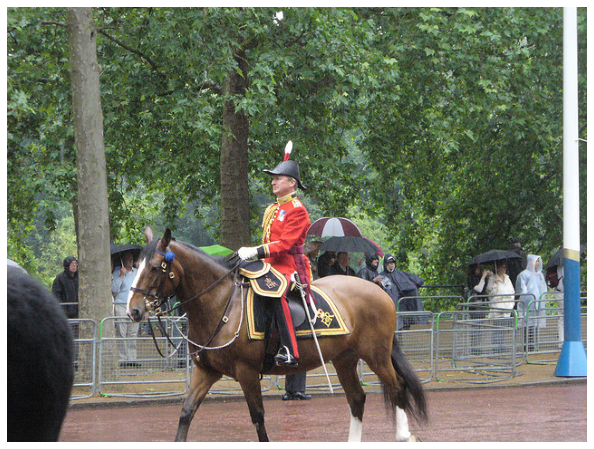

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

display_image(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Use CPU on Mac
cfg.MODEL.DEVICE = 'cpu'

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/Users/kanie/opt/anaconda3/envs/detectron2/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24])
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4209],
        [ 49.3953, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3803],
        [335.2410, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]]))


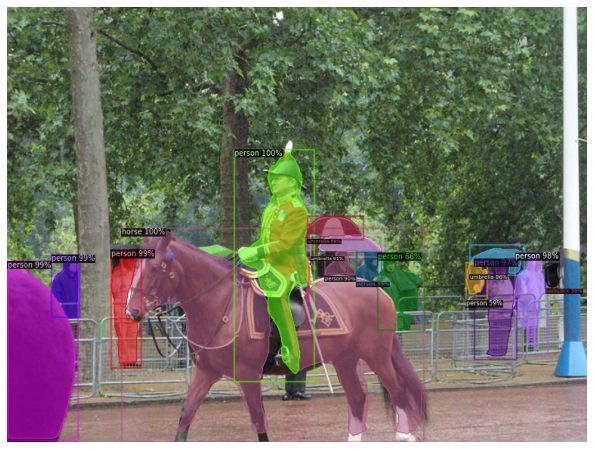

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display_image(out.get_image()[:, :, ::-1])

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [7]:
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs
import glob
from tqdm import tqdm

from detectron2.structures import BoxMode


def get_neocr_dicts(img_dir, xml_dir):
    ENCODE_METHOD = 'utf-8'
    num_files = len(os.listdir(xml_dir))

    dataset_dicts = []
    for idx, xml_file in tqdm(enumerate(glob.iglob(f'{xml_dir}/*.xml')), total=num_files):
        record = {}
        
        # process XML
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(xml_file, parser=parser).getroot()

        filename = os.path.join(img_dir, xmltree.find('filename').text)# ~.jpg
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        objs = []
        for object_iter in xmltree.findall('object'):

            polygon_iter = object_iter.find("polygon")

            rectangle = []
            for pt_iter in polygon_iter.findall("pt"):
                x = int(pt_iter.find('x').text)
                y = int(pt_iter.find('y').text)
                coordinate = [x, y]
                rectangle.append(coordinate)
            rectangle = np.array(rectangle)

            x_min, y_min = np.min(rectangle, axis=0)
            x_max, y_max = np.max(rectangle, axis=0)
            
            obj = {
                    "bbox": [x_min, y_min, x_max, y_max],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": 0,
                }
            
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [8]:
for d in ["train", "val"]:
    DatasetCatalog.register("neocr_" + d, lambda d=d: get_neocr_dicts("images/" + d, "annotations/" + d))
    MetadataCatalog.get("neocr_" + d).set(thing_classes=["text"])
neocr_metadata = MetadataCatalog.get("neocr_train")

In [9]:
dataset_dicts = get_neocr_dicts("images/train", "annotations/train")

100%|██████████| 528/528 [00:43<00:00, 12.17it/s]


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



**annotationがうまくいっていない画像があるのでそれを全部出力して省いたほうがいいかもしれない!!**

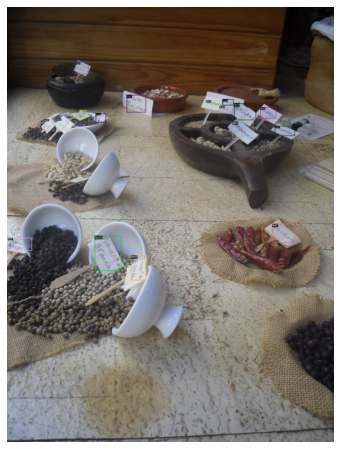

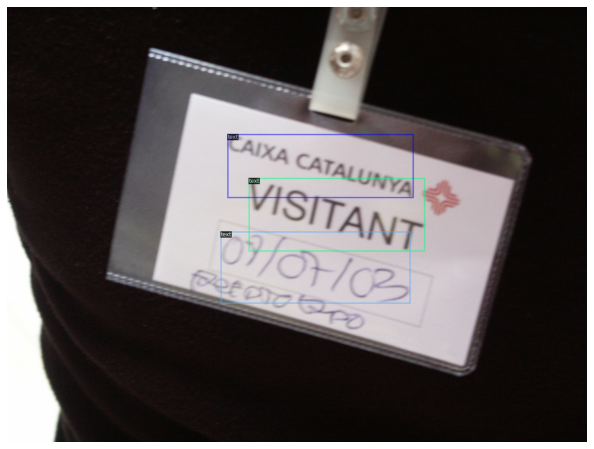

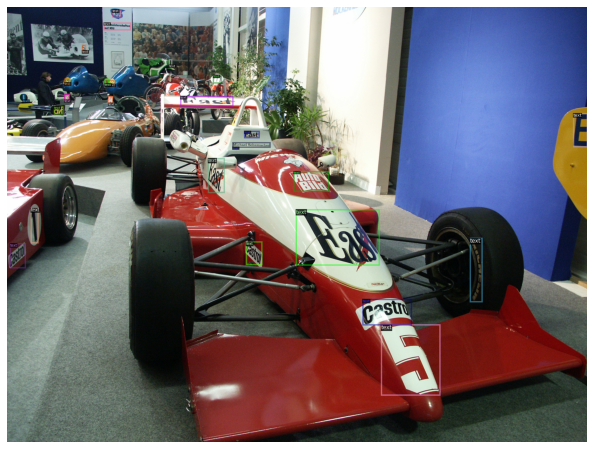

In [17]:
random.seed(50)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=neocr_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    display_image(out.get_image()[:, :, ::-1])

## Training in Google Colab

Now, let's fine-tune a COCO-pretrained R50-FPN R-CNN model on the neocr dataset.\
It takes 40 seconds to train 3 iterations on CPU.

### Usage of Detectron2
* [model_zoo package](https://detectron2.readthedocs.io/modules/model_zoo.html)
* [contents of config](https://github.com/facebookresearch/detectron2/tree/master/configs)


```python
from detectron2.engine import DefaultTrainer

# mask画像を使用しないので、model_zooは"COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"などを使用する
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # detect only box / Not use mask images
cfg.DATASETS.TRAIN = ("neocr_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("neocr_val", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo / only box / Not use mask images
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

# Use CPU on Mac
cfg.MODEL.DEVICE = 'cpu'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
```

## Inference by using the trained model
Now, let's run inference with the trained model in Google Colab on the neocr validation dataset.\
First, let's create a predictor using the model we just trained:

In [24]:
!system_profiler SPHardwareDataType

Hardware:

    Hardware Overview:

      Model Name: MacBook Air
      Model Identifier: MacBookAir9,1
      Processor Name: Quad-Core Intel Core i5
      Processor Speed: 1.1 GHz
      Number of Processors: 1
      Total Number of Cores: 4
      L2 Cache (per Core): 512 KB
      L3 Cache: 6 MB
      Hyper-Threading Technology: Enabled
      Memory: 16 GB
      Boot ROM Version: 1037.120.87.0.0 (iBridge: 17.16.15300.0.0,0)
      Serial Number (system): FVFCR3E5M6KK
      Hardware UUID: 6BB15AAF-9361-5BA3-AE1E-E802B021C71D
      Activation Lock Status: Enabled



In [28]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # detect only box / Not use mask images
cfg.DATASETS.TRAIN = ("neocr_train",)
cfg.DATASETS.TEST = ("neocr_val", )
cfg.DATALOADER.NUM_WORKERS = 2 # default 4
cfg.SOLVER.IMS_PER_BATCH = 2 # default 16
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR / default 0.001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (text)

cfg.MODEL.DEVICE = 'cpu' # Use CPU on Mac
cfg.OUTPUT_DIR = './output_prediction'
cfg.MODEL.WEIGHTS = "output_colab/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # create directory

predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [29]:
dataset_dicts = get_neocr_dicts("images/val", "annotations/val")

100%|██████████| 131/131 [00:09<00:00, 13.56it/s]


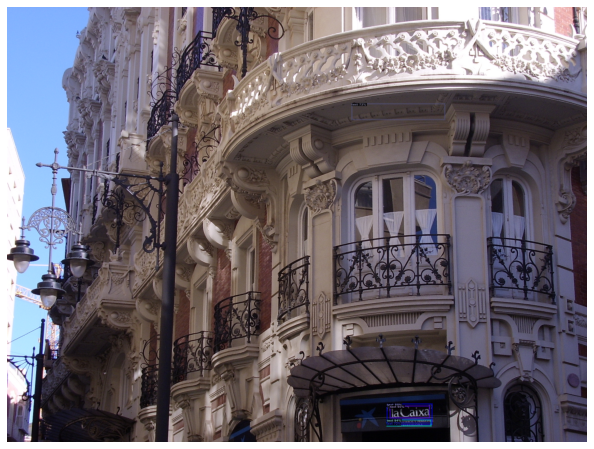

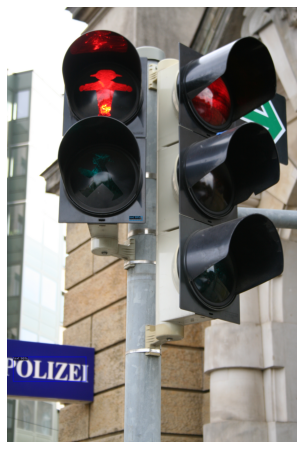

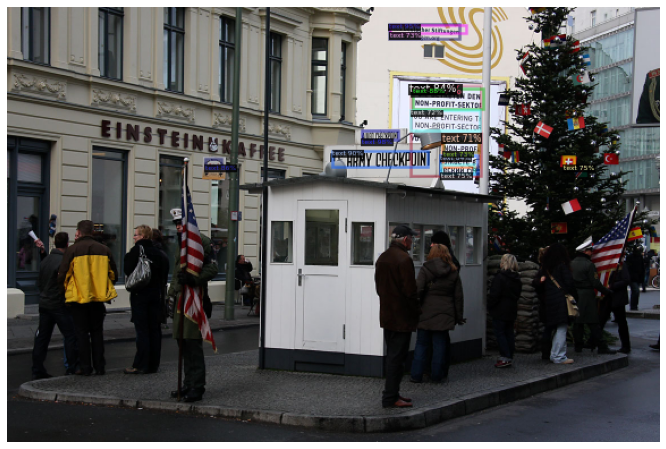

In [31]:
random.seed(10)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=neocr_metadata, 
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    display_image(out.get_image()[:, :, ::-1])

## Evaluate trained model
We can also evaluate its performance using AP metric implemented in COCO API.\
It takes ? minutes on CPU.\
This gives an AP of ~0. Bad???

In [36]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer

evaluator = COCOEvaluator("neocr_val", cfg, False, output_dir="./output_prediction/")
val_loader = build_detection_test_loader(cfg, "neocr_val")

trainer = DefaultTrainer(cfg)

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

100%|██████████| 131/131 [00:09<00:00, 13.61it/s]

[08/24 02:04:27 d2.data.common]: Serializing 131 elements to byte tensors and concatenating them all ...
[08/24 02:04:27 d2.data.common]: Serialized dataset takes 0.12 MiB
[08/24 02:04:27 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


[08/24 02:04:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 528/528 [00:42<00:00, 12.39it/s]

[08/24 02:05:10 d2.data.build]: Removed 0 images with no usable annotations. 528 images left.
[08/24 02:05:10 d2.data.common]: Serializing 528 elements to byte tensors and concatenating them all ...


[08/24 02:05:10 d2.data.common]: Serialized dataset takes 0.52 MiB
[08/24 02:05:10 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/24 02:05:10 d2.data.build]: Using training sampler TrainingSampler
[08/24 02:05:10 d2.evaluation.evaluator]: Start inference on 131 images
[08/24 02:05:16 d2.evaluation.evaluator]: Inference done 1/131. 5.7278 s / img. ETA=0:13:10
[08/24 02:05:23 d2.evaluation.evaluator]: Inference done 2/131. 5.9915 s / img. ETA=0:13:16
[08/24 02:05:29 d2.evaluation.evaluator]: Inference done 3/131. 6.2484 s / img. ETA=0:13:35
[08/24 02:05:36 d2.evaluation.evaluator]: Inference done 4/131. 6.3178 s / img. ETA=0:13:33
[08/24 02:05:42 d2.evaluation.evaluator]: Inference done 5/131. 6.2285 s / img. ETA=0:13:13
[08/24 02:05:48 d2.evaluation.evaluator]: Inference done 6/131. 6.5612 s / img. ETA=0:13:40
[08/24 02:05:54 d2.evaluation.evaluator]: 